# Problem II: Image Classification with Convolutional Neural Networks

**Learning Objectives**

In this notebook, we explore **image classification** using **Convolutional Neural Networks (CNNs)** — one of the most successful applications of deep learning. We will work with the **Fashion-MNIST** dataset, a modern replacement for the classic MNIST digits.

We will:
1. **Download** the Fashion-MNIST dataset from the internet
2. **Transform** images into PyTorch tensors with proper normalization
3. **Organize** data using `Dataset` and `DataLoader` for efficient training
4. (Later) Build and compare different CNN architectures
5. (Later) Train with various optimizers and analyze results

**Key Takeaway**: Understanding the data pipeline (download → transform → load) is foundational. A well-structured data pipeline enables reproducible experiments and efficient training.

# Step 1: Preparing the Data

## 1. Introduction: What is Image Classification?

**1.1 The Task**

**Image classification** is the task of assigning a label to an image from a fixed set of categories. Mathematically, we seek a function:

$$f_{\theta}: \mathcal{X} \rightarrow \mathcal{Y}$$

where:
- $\mathcal{X} = \mathbb{R}^{H \times W \times C}$ is the space of images (height $H$, width $W$, channels $C$)
- $\mathcal{Y} = \{0, 1, ..., K-1\}$ is the set of $K$ class labels
- $\theta$ are the learnable parameters of our model

For Fashion-MNIST:
- Images are grayscale: $H = W = 28$, $C = 1$
- There are $K = 10$ classes (T-shirt, Trouser, Pullover, etc.)

**1.2 Why Fashion-MNIST?**

The original MNIST (handwritten digits) has become too easy for modern methods, with accuracies exceeding 99.7%. Fashion-MNIST provides:

| Property | MNIST | Fashion-MNIST |
|----------|-------|---------------|
| Image size | 28×28 | 28×28 |
| Channels | 1 (grayscale) | 1 (grayscale) |
| Training samples | 60,000 | 60,000 |
| Test samples | 10,000 | 10,000 |
| Classes | 10 (digits 0-9) | 10 (clothing items) |
| Difficulty | Easy | Moderate |

**1.3 Why Convolutional Neural Networks?**

Standard fully-connected networks treat images as flat vectors, **ignoring** spatial structure. A 28×28 image becomes a 784-dimensional vector, **losing** the information that neighboring pixels are related.

**CNNs exploit spatial locality** through:
1. **Local connectivity**: Each neuron connects only to a local region
2. **Parameter sharing**: The same filter is applied across the entire image
3. **Translation Invariance**: A shifted input produces a shifted output

This makes CNNs dramatically more efficient and effective for image data.

## 2. Downloading the Data

**2.1 The Mathematical Setup**

Our dataset $\mathcal{D}$ consists of $N$ labeled examples:

$$\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^{N}$$

where:
- $\mathbf{x}^{(i)} \in \mathbb{R}^{28 \times 28}$ is the $i$-th image (pixel values in $[0, 255]$)
- $y^{(i)} \in \{0, 1, ..., 9\}$ is the corresponding class label

**2.2 PyTorch's torchvision.datasets**

PyTorch provides `torchvision.datasets` , a collection of popular datasets with automatic downloading capabilities. The key parameters are:

```python
FashionMNIST(
    root,        # Directory to store the data
    train,       # True for training set, False for test set
    download,    # True to download if not present
    transform    # Transformations to apply to images
)
```

**2.3 The Fashion-MNIST Classes**

| Label | Description |
|-------|-------------|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [21]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Used device is {device}')

Used device is mps


In [2]:
# Define the data directory
DATA_DIR = './data'

# Download Fashion-MNIST (without transforms for now, we'll add them in Section 3)
# This downloads ~30 MB of data
train_dataset_raw = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,           # Training set (60,000 images)
    download=True,        # Download if not already present
    transform=None        # No transform yet - raw PIL images
)

test_dataset_raw = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,          # Test set (10,000 images)
    download=True,
    transform=None
)

print(f"Training set size: {len(train_dataset_raw):,} images")
print(f"Test set size: {len(test_dataset_raw):,} images")

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:17<00:00, 1.48MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 183kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:03<00:00, 1.46MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 3.57MB/s]

Training set size: 60,000 images
Test set size: 10,000 images


In [3]:
# Define class names for interpretation
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Examine a single sample
sample_image, sample_label = train_dataset_raw[0]

print("="*60)
print("EXAMINING RAW DATA")
print("="*60)
print(f"\nImage type: {type(sample_image)}")
print(f"Image size: {sample_image.size}")
print(f"Image mode: {sample_image.mode}")
print(f"\nLabel: {sample_label}")
print(f"Class name: {CLASS_NAMES[sample_label]}")

EXAMINING RAW DATA

Image type: <class 'PIL.Image.Image'>
Image size: (28, 28)
Image mode: L

Label: 9
Class name: Ankle boot


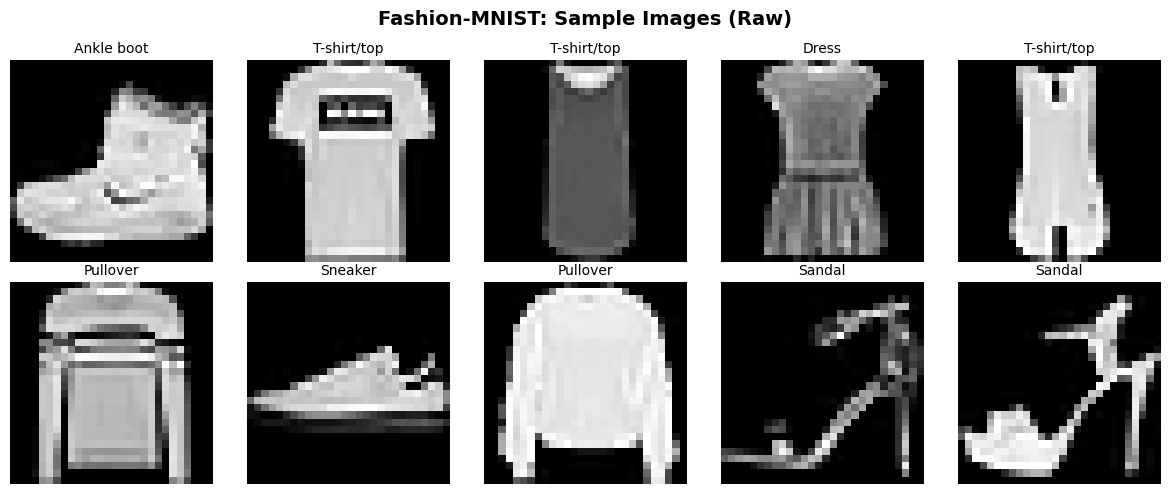

In [4]:
# Visualize some samples from the raw dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Fashion-MNIST: Sample Images (Raw)', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    image, label = train_dataset_raw[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'{CLASS_NAMES[label]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

**2.4 Understanding the Raw Data**

**Key Observations:**

1. **Format**: Raw images are PIL (Python Imaging Library) objects, not tensors
2. **Size**: Each image is 28×28 pixels
3. **Mode**: Grayscale ('L' mode = 8-bit pixels, range 0-255)
4. **Labels**: Integer indices 0-9 corresponding to class names

**Why can't we train directly on this?**

PyTorch neural networks require:
- Input as `torch.Tensor`, not PIL images
- Proper shape: `(batch_size, channels, height, width)` for CNNs
- Normalized values for stable training

This motivates Section 3: Transformations.

## 3. Transforming Images to PyTorch Tensors

**3.1 The Transformation Pipeline**

A **transform** is a function $T: \mathcal{X}_{\text{raw}} \rightarrow \mathcal{X}_{\text{processed}}$ that converts raw data into a format suitable for training. For images, we typically compose multiple transforms:

$$T = T_n \circ T_{n-1} \circ \cdots \circ T_1$$

In PyTorch, this is done with `transforms.Compose([T_1, T_2, ..., T_n])`.

**3.2 Essential Transforms**


**3.2.1 `ToTensor()`**

Converts a PIL Image or numpy array to a PyTorch tensor:

$$\text{ToTensor}: \text{PIL Image}_{H \times W} \rightarrow \text{Tensor}_{C \times H \times W}$$

**Crucially**, it also:
- Reorders dimensions from $(H, W, C)$ to $(C, H, W)$ (PyTorch convention)
- Rescales pixel values from $[0, 255]$ to $[0.0, 1.0]$ by dividing by 255


**3.2.2 `Normalize(mean, std)`**

Applies **standardization** (z-score normalization) to each channel:

$$\hat{x}_c = \frac{x_c - \mu_c}{\sigma_c}$$

where:
- $x_c$ is a pixel value in channel $c$
- $\mu_c$ is the mean of channel $c$ (computed over the training set)
- $\sigma_c$ is the standard deviation of channel $c$

**Why normalize?**

1. **Faster convergence**: Normalized inputs have similar scales, helping gradient descent
2. **Numerical stability**: Prevents very large or very small activations
3. **Better conditioning**: The loss landscape becomes more spherical

**3.3 Computing Dataset Statistics**

For proper normalization, we need the mean $\mu$ and standard deviation $\sigma$ of the training set. For Fashion-MNIST (single channel), we compute:

$$\mu = \frac{1}{N \cdot H \cdot W} \sum_{i=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} x^{(i)}_{h,w}$$

$$\sigma = \sqrt{\frac{1}{N \cdot H \cdot W} \sum_{i=1}^{N} \sum_{h=1}^{H} \sum_{w=1}^{W} (x^{(i)}_{h,w} - \mu)^2}$$

In [5]:
# First, let's compute the mean and std of Fashion-MNIST
# We need to load data as tensors (without normalization) to compute statistics

temp_transform = transforms.ToTensor()  # Only convert to tensor, values in [0, 1]

temp_dataset = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=False,
    transform=temp_transform
)

# Stack all images into a single tensor for efficient computation
# This creates a tensor of shape (60000, 1, 28, 28)
all_images = torch.stack([img for img, _ in temp_dataset])

print(f"All images shape: {all_images.shape}")
print(f"Memory usage: {all_images.numel() * 4 / 1e6:.1f} MB (float32)")

All images shape: torch.Size([60000, 1, 28, 28])
Memory usage: 188.2 MB (float32)


In [6]:
# Compute mean and std over all pixels
# Mean: average over all images (dim 0), all pixels (dims 2, 3)
mean = all_images.mean(dim=(0, 2, 3))  # Shape: (1,) for 1 channel
std = all_images.std(dim=(0, 2, 3))    # Shape: (1,) for 1 channel

print("="*60)
print("FASHION-MNIST STATISTICS")
print("="*60)
print(f"\nMean (μ): {mean.item():.4f}")
print(f"Std (σ):  {std.item():.4f}")
print(f"\nAfter normalization:")
print(f"  - Values will be centered around 0")
print(f"  - Most values will be in range [{-3*std.item():.2f}, {3*std.item():.2f}]")

# Store for later use
FASHION_MNIST_MEAN = (mean.item(),)
FASHION_MNIST_STD = (std.item(),)

FASHION-MNIST STATISTICS

Mean (μ): 0.2860
Std (σ):  0.3530

After normalization:
  - Values will be centered around 0
  - Most values will be in range [-1.06, 1.06]


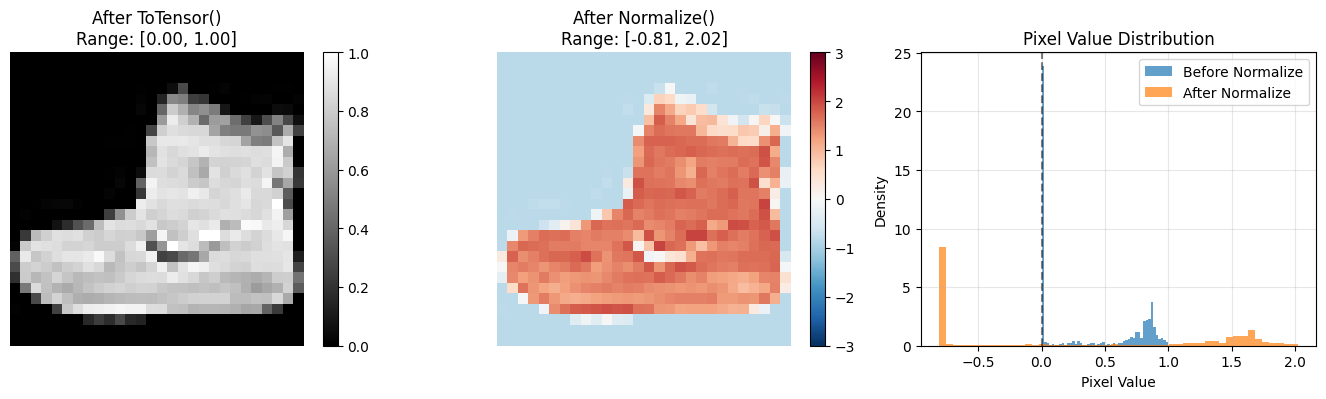

In [7]:
# Visualize the effect of normalization
sample_tensor = all_images[0]  # Shape: (1, 28, 28)

# Apply normalization manually
sample_normalized = (sample_tensor - mean.view(1, 1, 1)) / std.view(1, 1, 1)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Original (after ToTensor, before Normalize)
ax = axes[0]
im = ax.imshow(sample_tensor.squeeze(), cmap='gray')
ax.set_title(f'After ToTensor()\nRange: [{sample_tensor.min():.2f}, {sample_tensor.max():.2f}]')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Normalized
ax = axes[1]
im = ax.imshow(sample_normalized.squeeze(), cmap='RdBu_r', vmin=-3, vmax=3)
ax.set_title(f'After Normalize()\nRange: [{sample_normalized.min():.2f}, {sample_normalized.max():.2f}]')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Histogram comparison
ax = axes[2]
ax.hist(sample_tensor.flatten().numpy(), bins=50, alpha=0.7, label='Before Normalize', density=True)
ax.hist(sample_normalized.flatten().numpy(), bins=50, alpha=0.7, label='After Normalize', density=True)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Density')
ax.set_title('Pixel Value Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**3.4 Creating the Complete Transform Pipeline**

Now we define our complete transformation:

$$T = \text{Normalize} \circ \text{ToTensor}$$

In code:
```python
transform = transforms.Compose([
    transforms.ToTensor(),                    # PIL → Tensor, [0,255] → [0,1]
    transforms.Normalize(mean, std)           # Standardization
])
```

**Important**: 
- Apply the **same** transform to both training and test data
- Use statistics computed **only from training data** (to prevent data leakage)

In [8]:
# Define the complete transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor, scale to [0, 1]
    transforms.Normalize(FASHION_MNIST_MEAN, FASHION_MNIST_STD)  # Standardize
])

print("Transform pipeline:")
print(transform)
print(f"\nUsing mean={FASHION_MNIST_MEAN}, std={FASHION_MNIST_STD}")

Transform pipeline:
Compose(
    ToTensor()
    Normalize(mean=(0.28604060411453247,), std=(0.3530242443084717,))
)

Using mean=(0.28604060411453247,), std=(0.3530242443084717,)


In [9]:
# Create datasets with the transform applied
train_dataset = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=True,
    download=False,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root=DATA_DIR,
    train=False,
    download=False,
    transform=transform
)

# Verify the transformation
sample_tensor, sample_label = train_dataset[0]

print("="*60)
print("TRANSFORMED DATA VERIFICATION")
print("="*60)
print(f"\nTensor type: {type(sample_tensor)}")
print(f"Tensor dtype: {sample_tensor.dtype}")
print(f"Tensor shape: {sample_tensor.shape}  (C, H, W)")
print(f"\nValue range: [{sample_tensor.min():.3f}, {sample_tensor.max():.3f}]")
print(f"Mean: {sample_tensor.mean():.3f}")
print(f"Std: {sample_tensor.std():.3f}")
print(f"\nLabel: {sample_label} ({CLASS_NAMES[sample_label]})")

TRANSFORMED DATA VERIFICATION

Tensor type: <class 'torch.Tensor'>
Tensor dtype: torch.float32
Tensor shape: torch.Size([1, 28, 28])  (C, H, W)

Value range: [-0.810, 2.022]
Mean: 0.270
Std: 1.131

Label: 9 (Ankle boot)


**3.5 Summary: From PIL Image to Normalized Tensor**

The complete transformation pipeline:

```
PIL Image          ToTensor()           Normalize(μ, σ)
─────────────  ─────────────────────►  ─────────────────────►  PyTorch Tensor
• H×W pixels       • Shape: (1, 28, 28)    • Shape: (1, 28, 28)
• Values: 0-255    • Values: [0, 1]        • Values: centered at 0
• uint8            • float32               • float32
```

**What we achieved:**
- ✅ Converted PIL images to PyTorch tensors
- ✅ Correct shape for CNN: `(channels, height, width)`
- ✅ Normalized values for stable training

## 4. Shuffling, Splitting, and Loading Data

**4.1 Why Do We Need Training and Validation Sets?**

In machine learning, we split our data into:

| Set | Purpose | Usage |
|-----|---------|-------|
| **Training** | Learn parameters $\theta$ | Compute gradients, update weights |
| **Validation** | Tune hyperparameters, monitor overfitting | Evaluate without training |
| **Test** | Final unbiased evaluation | Report results (use only once!) |

The **validation set** is crucial for:
1. **Early stopping**: Stop training when validation loss stops improving
2. **Hyperparameter selection**: Choose learning rate, architecture, etc.
3. **Overfitting detection**: Training loss decreasing while validation loss increases

**4.2 The Mathematics of Data Splitting**

Given a dataset $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^{N}$, we partition it into disjoint subsets:

$$\mathcal{D} = \mathcal{D}_{\text{train}} \cup \mathcal{D}_{\text{val}} \cup \mathcal{D}_{\text{test}}$$

with $\mathcal{D}_{\text{train}} \cap \mathcal{D}_{\text{val}} = \emptyset$, etc.

Common split ratios:
- Training: 80% (48,000 images)
- Validation: 20% (12,000 images)  
- Test: Separate (10,000 images — already provided)

**4.3 Why Shuffle?**

**Shuffling** randomizes the order of training samples. This is critical because:

1. **Breaks correlations**: If data is ordered (e.g., all class 0, then all class 1...), the network might learn spurious patterns

2. **Better gradient estimates**: Mini-batch gradients are noisy estimates of the true gradient. Shuffling ensures each batch is representative:

$$\nabla_{\theta} \mathcal{L}(\theta) \approx \frac{1}{|B|} \sum_{i \in B} \nabla_{\theta} \ell(f_\theta(\mathbf{x}^{(i)}), y^{(i)})$$

where $B$ is a randomly sampled mini-batch.

3. **Regularization effect**: Different orderings each epoch act as a form of regularization

**Important**: 
- Shuffle **training data**: Yes (every epoch)
- Shuffle **validation/test data**: No (for reproducibility)

**Terminology Note**: Fashion-MNIST comes pre-split into train=True (60,000) and train=False (10,000). The train=False portion is the held-out test set we'll use for final evaluation. We further split the train=True portion into our working training set (48,000) and validation set (12,000). This gives us three disjoint sets.

In [10]:
# Split the training set into training and validation
# Fashion-MNIST provides 60,000 training images
# We'll use 80% for training (48,000) and 20% for validation (12,000)

TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(train_dataset))
val_size = len(train_dataset) - train_size

print(f"Original training set: {len(train_dataset):,} images")
print(f"Split ratio: {TRAIN_RATIO:.0%} train / {1-TRAIN_RATIO:.0%} validation")
print(f"\nAfter split:")
print(f"  Training:   {train_size:,} images")
print(f"  Validation: {val_size:,} images")
print(f"  Test:       {len(test_dataset):,} images (separate)")

Original training set: 60,000 images
Split ratio: 80% train / 20% validation

After split:
  Training:   48,000 images
  Validation: 12,000 images
  Test:       10,000 images (separate)


In [11]:
# Perform the split using random_split
# This creates two Subset objects that reference the original dataset
# The split is randomized based on the generator seed

generator = torch.Generator().manual_seed(42)  # For reproducibility

train_subset, val_subset = random_split(
    train_dataset, 
    [train_size, val_size],
    generator=generator
)

print(f"Train subset type: {type(train_subset)}")
print(f"Train subset size: {len(train_subset)}")
print(f"Val subset size: {len(val_subset)}")

Train subset type: <class 'torch.utils.data.dataset.Subset'>
Train subset size: 48000
Val subset size: 12000


**4.4 DataLoader: Efficient Batched Data Loading**

The `DataLoader` is PyTorch's utility for:
1. **Batching**: Grouping samples into mini-batches
2. **Shuffling**: Randomizing order each epoch
3. **Parallel loading**: Using multiple workers for speed
4. **Memory efficiency**: Loading data on-demand

**4.4.1 Mini-Batch Gradient Descent**

Instead of computing gradients over the entire dataset (**batch gradient descent**) or single samples (**stochastic gradient descent**), we use **mini-batches** of size $B$:

$$\theta \leftarrow \theta - \eta \cdot \frac{1}{B} \sum_{i=1}^{B} \nabla_\theta \ell(f_\theta(\mathbf{x}^{(i)}), y^{(i)})$$

| Method | Batch Size | Pros | Cons |
|--------|------------|------|------|
| Batch GD | $N$ (all) | Stable, accurate gradient | Slow, memory-intensive |
| SGD | 1 | Fast updates, escapes minima | Noisy, unstable |
| Mini-batch | $B$ (e.g., 32-256) | Best of both worlds | Requires tuning $B$ |

**4.4.2 DataLoader Parameters**

```python
DataLoader(
    dataset,         # The dataset to load from
    batch_size,      # Number of samples per batch
    shuffle,         # Whether to shuffle at each epoch
    num_workers,     # Parallel data loading processes
    pin_memory,      # Speed up CPU-to-GPU transfer
    drop_last        # Drop incomplete final batch
)
```

In [12]:
# Define batch size - a crucial hyperparameter
BATCH_SIZE = 64

# Create DataLoaders
train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle training data each epoch
    num_workers=2,          # Parallel data loading (adjust based on your system)
    pin_memory=True         # Faster CPU→GPU transfer if using CUDA
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle validation data
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle test data
    num_workers=2,
    pin_memory=True
)

print("="*60)
print("DATALOADER CONFIGURATION")
print("="*60)
print(f"\nBatch size: {BATCH_SIZE}")
print(f"\nNumber of batches:")
print(f"  Training:   {len(train_loader):,} batches × {BATCH_SIZE} = {len(train_loader)*BATCH_SIZE:,} samples/epoch")
print(f"  Validation: {len(val_loader):,} batches")
print(f"  Test:       {len(test_loader):,} batches")

DATALOADER CONFIGURATION

Batch size: 64

Number of batches:
  Training:   750 batches × 64 = 48,000 samples/epoch
  Validation: 188 batches
  Test:       157 batches


In [13]:
# Examine a single batch
# iter() creates an iterator, next() gets the first batch
sample_batch_images, sample_batch_labels = next(iter(train_loader))

print("="*60)
print("EXAMINING A SINGLE BATCH")
print("="*60)
print(f"\nImages tensor shape: {sample_batch_images.shape}")
print(f"  → (batch_size, channels, height, width)")
print(f"  → ({BATCH_SIZE}, 1, 28, 28)")
print(f"\nLabels tensor shape: {sample_batch_labels.shape}")
print(f"Labels dtype: {sample_batch_labels.dtype}")
print(f"\nSample labels: {sample_batch_labels[:10].tolist()}")
print(f"Class names: {[CLASS_NAMES[l] for l in sample_batch_labels[:10].tolist()]}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


EXAMINING A SINGLE BATCH

Images tensor shape: torch.Size([64, 1, 28, 28])
  → (batch_size, channels, height, width)
  → (64, 1, 28, 28)

Labels tensor shape: torch.Size([64])
Labels dtype: torch.int64

Sample labels: [9, 8, 2, 6, 9, 0, 3, 5, 2, 1]
Class names: ['Ankle boot', 'Bag', 'Pullover', 'Shirt', 'Ankle boot', 'T-shirt/top', 'Dress', 'Sandal', 'Pullover', 'Trouser']


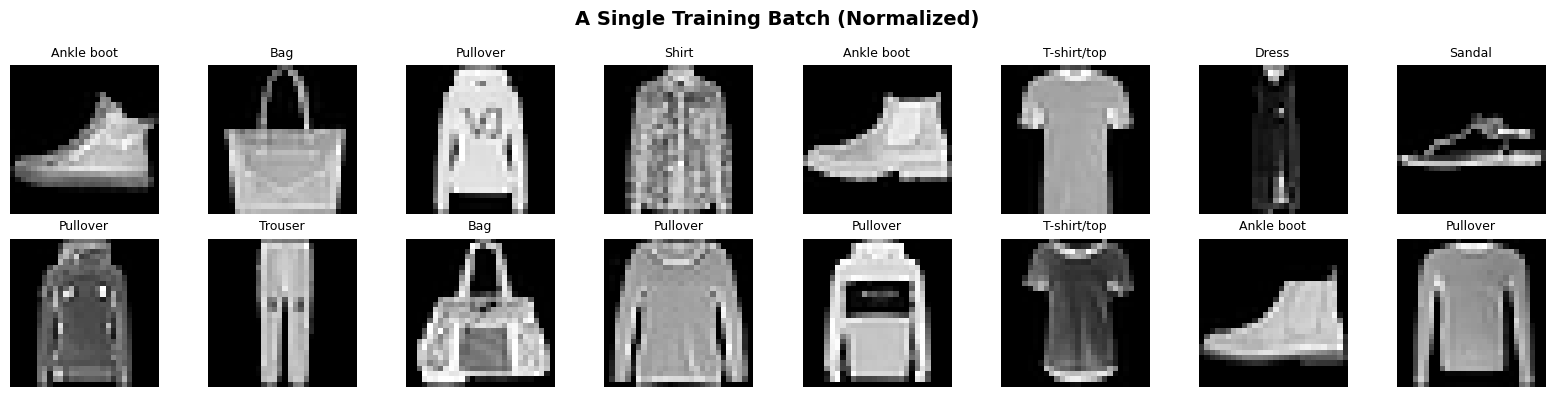

In [14]:
# Visualize a batch of normalized images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('A Single Training Batch (Normalized)', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Denormalize for visualization: x = x * std + mean
    img = sample_batch_images[i].squeeze()  # Remove channel dimension
    img_denorm = img * FASHION_MNIST_STD[0] + FASHION_MNIST_MEAN[0]
    
    ax.imshow(img_denorm.numpy(), cmap='gray')
    ax.set_title(f'{CLASS_NAMES[sample_batch_labels[i]]}', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

**4.5 Verifying Class Distribution**

A good data split should maintain the **class distribution** (stratification). Let's verify that our random split didn't accidentally create an imbalanced training or validation set.

In [15]:
# Count class distribution in each split
def count_classes(subset, num_classes=10):
    """Count the number of samples per class in a subset."""
    counts = torch.zeros(num_classes, dtype=torch.int64)
    for _, label in subset:
        counts[label] += 1
    return counts

print("Computing class distributions")
train_counts = count_classes(train_subset)
val_counts = count_classes(val_subset)
test_counts = count_classes(test_dataset)

print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)
print(f"\n{'Class':<15} {'Train':>10} {'Val':>10} {'Test':>10}")
print("-"*45)
for i, name in enumerate(CLASS_NAMES):
    print(f"{name:<15} {train_counts[i]:>10,} {val_counts[i]:>10,} {test_counts[i]:>10,}")
print("-"*45)
print(f"{'Total':<15} {train_counts.sum():>10,} {val_counts.sum():>10,} {test_counts.sum():>10,}")

Computing class distributions

CLASS DISTRIBUTION

Class                Train        Val       Test
---------------------------------------------
T-shirt/top          4,732      1,268      1,000
Trouser              4,752      1,248      1,000
Pullover             4,825      1,175      1,000
Dress                4,852      1,148      1,000
Coat                 4,807      1,193      1,000
Sandal               4,797      1,203      1,000
Shirt                4,788      1,212      1,000
Sneaker              4,866      1,134      1,000
Bag                  4,805      1,195      1,000
Ankle boot           4,776      1,224      1,000
---------------------------------------------
Total               48,000     12,000     10,000


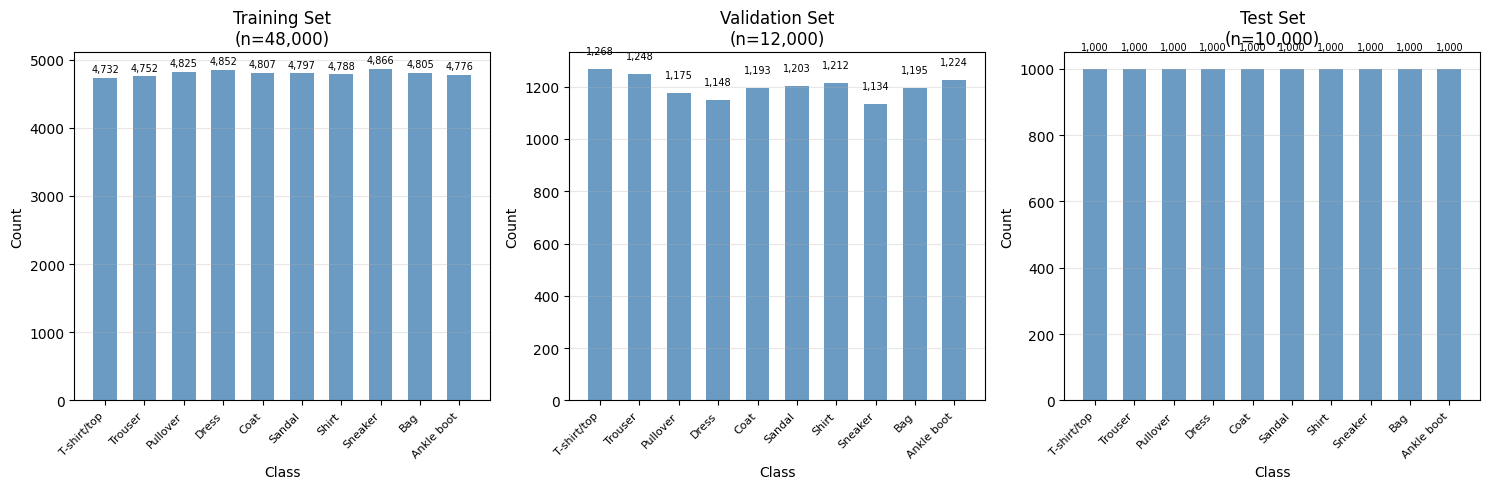


✓ The class distribution is approximately balanced across all splits.
  This is expected since Fashion-MNIST is originally balanced (6,000 per class in train).


In [16]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(len(CLASS_NAMES))
width = 0.6

for ax, counts, title in zip(axes, 
                              [train_counts, val_counts, test_counts],
                              ['Training Set', 'Validation Set', 'Test Set']):
    bars = ax.bar(x, counts.numpy(), width, color='steelblue', alpha=0.8)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(f'{title}\n(n={counts.sum():,})')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right', fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count:,}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

print("\n✓ The class distribution is approximately balanced across all splits.")
print("  This is expected since Fashion-MNIST is originally balanced (6,000 per class in train).")

**4.6 The Training Loop Preview**

Now that we have our DataLoaders set up, here's how they will be used in training:

```python
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for batch_images, batch_labels in train_loader:  # Automatically shuffled!
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass, loss, backward pass, optimizer step
        ...
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:  # Not shuffled
            # Compute validation metrics
            ...
```

In [17]:
# Demonstrate that training data is shuffled each epoch
print("Demonstrating shuffling behavior:")
print("="*60)

# Get first batch labels from two different "epochs" (iterations over the loader)
first_epoch_labels = next(iter(train_loader))[1][:10].tolist()
second_epoch_labels = next(iter(train_loader))[1][:10].tolist()

print(f"\nFirst 10 labels (epoch 1):  {first_epoch_labels}")
print(f"First 10 labels (epoch 2):  {second_epoch_labels}")
print(f"\nAre they the same? {first_epoch_labels == second_epoch_labels}")
print("\n→ Each epoch sees the data in a different (random) order!")

Demonstrating shuffling behavior:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



First 10 labels (epoch 1):  [4, 3, 5, 0, 1, 5, 5, 7, 6, 3]
First 10 labels (epoch 2):  [0, 4, 5, 6, 2, 2, 9, 0, 6, 1]

Are they the same? False

→ Each epoch sees the data in a different (random) order!


## 5. Summary: The Complete Data Pipeline


We have established a complete data pipeline for image classification:
```
┌─────────────────────────────────────────────────────────────────────────────┐
│                           DATA PIPELINE OVERVIEW                            │
└─────────────────────────────────────────────────────────────────────────────┘

    Internet                   Local Storage              PyTorch Dataset
    ────────                   ─────────────              ───────────────
    Fashion-MNIST    download     ./data/        transform    train_dataset (60,000)
    (compressed)  ───────────►  (raw files)  ─────────────►  test_dataset  (10,000)
                                                                   │
                                                    ┌──────────────┴──────────────┐
                                                    │                             │
                                                    ▼                             │
                                             train_dataset                        │
                                                    │                             │
                                                    │ random_split                │
                                                    ▼                             │
                                          ┌─────────────────┐                     │
                                          │ train_subset    │                     │
                                          │ (48,000)        │                     │
                                          ├─────────────────┤                     │
                                          │ val_subset      │                     │
                                          │ (12,000)        │                     │
                                          └─────────────────┘                     │
                                                    │                             │
                                                    │ DataLoader                  │ DataLoader
                                                    ▼                             ▼
                                          ┌─────────────────────────────────────────┐
                                          │ train_loader (shuffle=True)             │
                                          │ val_loader   (shuffle=False)            │
                                          │ test_loader  (shuffle=False)            │
                                          └─────────────────────────────────────────┘
                                                              │
                                                              │ for batch in loader
                                                              ▼
                                                    ┌─────────────────┐
                                                    │     BATCHES     │
                                                    │ (64, 1, 28, 28) │
                                                    └─────────────────┘
```


**Key Takeaways**

| Step | What We Did | Why It Matters |
|------|-------------|----------------|
| **Download** | `FashionMNIST(download=True)` | Automatic data acquisition |
| **Transform** | `ToTensor()` + `Normalize()` | Correct format & scale for NNs |
| **Split** | `random_split(train, [80%, 20%])` | Separate train/val for monitoring |
| **Load** | `DataLoader(shuffle=True)` | Efficient batched iteration |

**Dataset Sizes**

| Set | Samples | Batches (size 64) | Purpose |
|-----|---------|-------------------|----------|
| Training | 48,000 | 750 | Learn parameters |
| Validation | 12,000 | 188 | Monitor & tune |
| Test | 10,000 | 157 | Final evaluation |

**Next Steps**

With our data pipeline complete, we are ready to:
1. Build CNN architectures
2. Train with various optimizers
3. Evaluate and compare results

In [18]:
# Final verification: Print all key variables
print("="*60)
print("DATA PIPELINE READY FOR TRAINING")
print("="*60)
print(f"\n✓ Device: {device}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Image shape: (1, 28, 28)")
print(f"✓ Number of classes: {len(CLASS_NAMES)}")
print(f"✓ Normalization: mean={FASHION_MNIST_MEAN[0]:.4f}, std={FASHION_MNIST_STD[0]:.4f}")
print(f"\n✓ train_loader: {len(train_loader)} batches ({len(train_subset):,} samples)")
print(f"✓ val_loader: {len(val_loader)} batches ({len(val_subset):,} samples)")
print(f"✓ test_loader: {len(test_loader)} batches ({len(test_dataset):,} samples)")
print(f"\n" + "="*60)
print("Ready for model building and training!")
print("="*60)

DATA PIPELINE READY FOR TRAINING

✓ Device: mps
✓ Batch size: 64
✓ Image shape: (1, 28, 28)
✓ Number of classes: 10
✓ Normalization: mean=0.2860, std=0.3530

✓ train_loader: 750 batches (48,000 samples)
✓ val_loader: 188 batches (12,000 samples)
✓ test_loader: 157 batches (10,000 samples)

Ready for model building and training!


# Step 2: Building the Neural Network

## 1. Introduction: From Images to Predictions

**1.1 The Goal**

We want to build a neural network that maps images to class probabilities:

$$f_\theta: \mathbb{R}^{1 \times 28 \times 28} \rightarrow \mathbb{R}^{10}$$

The output is a **probability distribution** over the 10 classes. For an input image $\mathbf{x}$, the network outputs:

$$\hat{\mathbf{y}} = \text{softmax}(f_\theta(\mathbf{x})) \in \mathbb{R}^{10}, \quad \text{where } \sum_{k=0}^{9} \hat{y}_k = 1$$

The predicted class is: $\hat{c} = \arg\max_k \hat{y}_k$

**1.2 Why LeNet-5?**

LeNet-5, introduced by Yann LeCun in 1998, is one of the **pioneering CNN architectures**. It was originally designed for handwritten digit recognition and is perfectly suited for Fashion-MNIST because:

| Property | LeNet-5 Design Choice | Why It Works |
|----------|----------------------|---------------|
| Small images (28×28) | Small receptive fields (5×5 kernels) | Captures local patterns efficiently |
| Grayscale (1 channel) | Single input channel | No need for RGB processing |
| 10 classes | 10 output neurons | Direct class mapping |
| Limited compute (1998) | ~60K parameters | Fast training, interpretable |

**Historical Note**: LeNet-5 demonstrated that neural networks could achieve human-level performance on digit recognition, sparking the modern deep learning revolution.

**1.3 Architecture Overview**

LeNet-5 follows a classic pattern: **Feature Extraction → Classification**

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                        LeNet-5 ARCHITECTURE OVERVIEW                         │
└─────────────────────────────────────────────────────────────────────────────┘

   Input Image        FEATURE EXTRACTION              CLASSIFICATION
   ───────────      ─────────────────────────        ────────────────────
   (1, 28, 28)      Conv → Pool → Conv → Pool  →     Flatten → FC → FC → FC
       │                     │                              │
       │                     │                              │
       ▼                     ▼                              ▼
   Raw Pixels          Feature Maps                  Class Probabilities
                   (hierarchical features)              (10 outputs)
```

The network progressively:
1. **Extracts local features** (edges, textures) with convolutions
2. **Reduces spatial dimensions** with pooling
3. **Combines features** into a global representation
4. **Classifies** using fully-connected layers

## 2. Pooling Layers

**For detailed explanation about the Convolutional Layers please check Layers.ipynb**


**Pooling Layers: Spatial Downsampling**

**2.1 Why Pooling?**

Pooling serves three critical purposes:

1. **Reduces spatial dimensions** → Fewer parameters in subsequent layers
2. **Provides translation invariance** → Small shifts in input don't change output
3. **Controls overfitting** → Summarizes feature presence

**2.2 Max Pooling**

Max pooling takes the **maximum value** within each pooling window:

$$\mathbf{Y}_{i,j} = \max_{(m,n) \in R_{i,j}} \mathbf{X}_{m,n}$$

where $R_{i,j}$ is the pooling region centered at position $(i,j)$.

**Visual Example** (2×2 max pooling with stride 2):

```
Input (4×4):              Output (2×2):
┌───┬───┬───┬───┐         ┌───┬───┐
│ 1 │ 3 │ 2 │ 1 │         │ 4 │ 6 │  (max of each 2×2 region)
├───┼───┼───┼───┤    →    ├───┼───┤
│ 4 │ 2 │ 6 │ 4 │         │ 8 │ 5 │
├───┼───┼───┼───┤         └───┴───┘
│ 1 │ 8 │ 3 │ 5 │
├───┼───┼───┼───┤
│ 2 │ 1 │ 2 │ 3 │
└───┴───┴───┴───┘
```

**Intuition**: If a feature (edge, texture) is detected *anywhere* in the pooling region, max pooling preserves it. This provides robustness to small translations.

**2.3 Average Pooling (LeNet-5 Original)**

The original LeNet-5 used average pooling (called "subsampling"):

$$\mathbf{Y}_{i,j} = \frac{1}{|R_{i,j}|} \sum_{(m,n) \in R_{i,j}} \mathbf{X}_{m,n}$$

**Modern Practice**: Max pooling is more commonly used today as it tends to preserve the strongest activations, but both work well.

**2.4 Output Size Formula**

For pooling with window size $k$ and stride $s$ (typically $k = s$):

$$H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} - k}{s} \right\rfloor + 1$$

**Example**: Input 24×24, kernel 2×2, stride 2:
$$H_{\text{out}} = \left\lfloor \frac{24 - 2}{2} \right\rfloor + 1 = 11 + 1 = 12$$

**Important**: Pooling has **no learnable parameters**!

In [22]:
# Demonstration: Understanding Pooling
print("="*60)
print("UNDERSTANDING POOLING")
print("="*60)

# Create pooling layers
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

# Example: after first conv, we have 24×24 feature maps
feature_map = torch.randn(1, 6, 24, 24)  # 6 channels, 24×24 each

# Apply pooling
max_pooled = max_pool(feature_map)
avg_pooled = avg_pool(feature_map)

print(f"\nInput shape:       {feature_map.shape}")
print(f"After MaxPool2d:   {max_pooled.shape}")
print(f"After AvgPool2d:   {avg_pooled.shape}")

print(f"\nDimension calculation:")
print(f"  H_out = floor((24 - 2) / 2) + 1 = floor(22/2) + 1 = 12")

print(f"\nParameters in pooling: {sum(p.numel() for p in max_pool.parameters())}")
print("  → Pooling has NO learnable parameters!")

UNDERSTANDING POOLING

Input shape:       torch.Size([1, 6, 24, 24])
After MaxPool2d:   torch.Size([1, 6, 12, 12])
After AvgPool2d:   torch.Size([1, 6, 12, 12])

Dimension calculation:
  H_out = floor((24 - 2) / 2) + 1 = floor(22/2) + 1 = 12

Parameters in pooling: 0
  → Pooling has NO learnable parameters!


## 3. LeNet-5 Architecture

**3.1 Complete Architecture Diagram**

Here is the full LeNet-5 architecture adapted for Fashion-MNIST (28×28 input):

```
┌─────────────────────────────────────────────────────────────────────────────────────────┐
│                                   LeNet-5 ARCHITECTURE                                   │
└─────────────────────────────────────────────────────────────────────────────────────────┘

Layer           Operation              Input Shape    Output Shape   Parameters
─────────────────────────────────────────────────────────────────────────────────────────
INPUT           -                      (1, 28, 28)    (1, 28, 28)    0

CONV1           Conv2d(1→6, k=5)       (1, 28, 28)    (6, 24, 24)    156
                ReLU                   (6, 24, 24)    (6, 24, 24)    0
POOL1           MaxPool2d(k=2, s=2)    (6, 24, 24)    (6, 12, 12)    0

CONV2           Conv2d(6→16, k=5)      (6, 12, 12)    (16, 8, 8)     2,416
                ReLU                   (16, 8, 8)     (16, 8, 8)     0
POOL2           MaxPool2d(k=2, s=2)    (16, 8, 8)     (16, 4, 4)     0

FLATTEN         view(-1)               (16, 4, 4)     (256,)         0

FC1             Linear(256→120)        (256,)         (120,)         30,840
                ReLU                   (120,)         (120,)         0

FC2             Linear(120→84)         (120,)         (84,)          10,164
                ReLU                   (84,)          (84,)          0

FC3 (Output)    Linear(84→10)          (84,)          (10,)          850
─────────────────────────────────────────────────────────────────────────────────────────
TOTAL PARAMETERS:                                                    44,426
```

**3.2 Layer-by-Layer Analysis**

| Stage | Purpose | Key Insight |
|-------|---------|-------------|
| **Conv1 + Pool1** | Detect low-level features | Edges, corners, simple textures |
| **Conv2 + Pool2** | Detect higher-level features | Combinations of low-level features |
| **FC1 + FC2** | Learn non-linear combinations | Global reasoning about the image |
| **FC3** | Final classification | One score per class |

**3.3 Why This Architecture Works**

1. **Progressive abstraction**: Early layers detect simple patterns; later layers combine them
2. **Spatial hierarchy**: $28 \rightarrow 24 \rightarrow 12 \rightarrow 8 \rightarrow 4$ pixels
3. **Channel growth**: $1 \rightarrow 6 \rightarrow 16$ channels (more features as spatial dims shrink)
4. **Efficiency**: Most parameters are in FC layers, but conv layers do the heavy lifting

## 4. Implementation

In [38]:
class LeNet5(nn.Module):
    """
    LeNet-5 Architecture for Fashion-MNIST
    
    Architecture:
        Input: (batch, 1, 28, 28) - Grayscale images
        
        Feature Extraction:
            Conv1: 1 → 6 channels, 5×5 kernel  → (batch, 6, 24, 24)
            ReLU + MaxPool(2×2)                → (batch, 6, 12, 12)
            Conv2: 6 → 16 channels, 5×5 kernel → (batch, 16, 8, 8)
            ReLU + MaxPool(2×2)                → (batch, 16, 4, 4)
        
        Classification:
            Flatten                            → (batch, 256)
            FC1: 256 → 120 + ReLU              → (batch, 120)
            FC2: 120 → 84 + ReLU               → (batch, 84)
            FC3: 84 → 10 (logits)              → (batch, 10)
        
        Output: (batch, 10) - Raw scores for each class
    
    Total Parameters: 44,426
    """
    def __init__(self, num_classes: int = 10):
        """
        Initialize LeNet-5 architecture. 
        Args:
            num_classes: Number of output classes (default: 10 for Fashion-MNIST)
        """
        super().__init__()
        self.flatten = nn.Flatten()
        # =====================================================================
        # FEATURE EXTRACTION LAYERS
        # =====================================================================
        
        # First convolutional block
        # Input: (batch, 1, 28, 28) → Output: (batch, 6, 24, 24)
        # Parameters: 6 × (1 × 5 × 5 + 1) = 156
        self.conv1 = nn.Conv2d(
            in_channels=1,      # Grayscale input
            out_channels=6,     # 6 feature maps (different pattern detectors)
            kernel_size=5,      # 5×5 receptive field
            stride=1,           # Move 1 pixel at a time
            padding=0           # No padding → output shrinks
        )
        
        # Second convolutional block
        # Input: (batch, 6, 12, 12) → Output: (batch, 16, 8, 8)
        # Parameters: 16 × (6 × 5 × 5 + 1) = 2,416
        self.conv2 = nn.Conv2d(
            in_channels=6,      # From previous conv layer
            out_channels=16,    # 16 feature maps (more patterns)
            kernel_size=5,
            stride=1,
            padding=0
        )
        
        # Pooling layer (shared between both conv blocks)
        # Reduces spatial dimensions by factor of 2
        # Parameters: 0 (no learnable parameters)
        self.pool = nn.MaxPool2d(
            kernel_size=2,      # 2×2 pooling window
            stride=2            # Non-overlapping windows
        )
        
        # =====================================================================
        # CLASSIFICATION LAYERS
        # =====================================================================
        
        # After conv2 + pool: (batch, 16, 4, 4) → flatten → (batch, 256)
        
        # First fully connected layer
        # Parameters: 256 × 120 + 120 = 30,840
        self.fc1 = nn.Linear(
            in_features=16 * 4 * 4,  # 256 (flattened conv output)
            out_features=120         # Hidden units
        )
        
        # Second fully connected layer
        # Parameters: 120 × 84 + 84 = 10,164
        self.fc2 = nn.Linear(
            in_features=120,
            out_features=84
        )
        
        # Output layer (no activation - produces logits)
        # Parameters: 84 × 10 + 10 = 850
        self.fc3 = nn.Linear(
            in_features=84,
            out_features=num_classes
        )
        
        # Activation function (used multiple times, no parameters)
        self.relu = nn.ReLU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)
        
        Returns:
            Logits of shape (batch_size, num_classes)
        """
        # =====================================================================
        # FEATURE EXTRACTION
        # =====================================================================
        
        # Block 1: Conv → ReLU → Pool
        # (batch, 1, 28, 28) → (batch, 6, 24, 24) → (batch, 6, 12, 12)
        x = self.conv1(x)           # Convolution: detect local patterns
        x = self.relu(x)            # Non-linearity: enable complex functions
        x = self.pool(x)            # Pooling: reduce spatial dimensions
        
        # Block 2: Conv → ReLU → Pool
        # (batch, 6, 12, 12) → (batch, 16, 8, 8) → (batch, 16, 4, 4)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # =====================================================================
        # CLASSIFICATION
        # =====================================================================
        
        # Flatten: (batch, 16, 4, 4) → (batch, 256)
        x = self.flatten(x)   # Keep batch dimension, flatten the rest
        
        # FC layers with ReLU
        x = self.relu(self.fc1(x))  # (batch, 256) → (batch, 120)
        x = self.relu(self.fc2(x))  # (batch, 120) → (batch, 84)
        
        # Output layer (no activation - CrossEntropyLoss expects logits)
        x = self.fc3(x)             # (batch, 84) → (batch, 10)
        
        return x

In [39]:
# Model Verification and Analysis
model = LeNet5(num_classes=10).to(device)

print("="*60)
print("MODEL INSTANTIATION")
print("="*60)
print(f"\nDevice: {device}")
print(f"Model type: {type(model).__name__}")
print(f"\nArchitecture:\n{model}")

# Detailed parameter analysis
print("="*60)
print("PARAMETER ANALYSIS")
print("="*60)

# Count parameters by layer
total_params = 0
trainable_params = 0

print(f"\n{'Layer':<20} {'Shape':<20} {'Parameters':>12}")
print("-" * 55)

for name, param in model.named_parameters():
    layer_params = param.numel()
    total_params += layer_params
    if param.requires_grad:
        trainable_params += layer_params
    print(f"{name:<20} {str(tuple(param.shape)):<20} {layer_params:>12,}")

print("-" * 55)
print(f"{'TOTAL':<20} {'':<20} {total_params:>12,}")
print(f"{'Trainable':<20} {'':<20} {trainable_params:>12,}")

# Verify our manual calculation
print(f"\n\nVerification:")
print(f"  Conv1: 6 × (1 × 5 × 5 + 1) = {6 * (1 * 5 * 5 + 1)}")
print(f"  Conv2: 16 × (6 × 5 × 5 + 1) = {16 * (6 * 5 * 5 + 1)}")
print(f"  FC1:   256 × 120 + 120 = {256 * 120 + 120}")
print(f"  FC2:   120 × 84 + 84 = {120 * 84 + 84}")
print(f"  FC3:   84 × 10 + 10 = {84 * 10 + 10}")
print(f"  ────────────────────────")
print(f"  Total: {156 + 2416 + 30840 + 10164 + 850}")


# Test forward pass with actual data
print("="*60)
print("FORWARD PASS VERIFICATION")
print("="*60)

# Get a batch from train_loader (defined in Step 1)
sample_batch, sample_labels = next(iter(train_loader))
sample_batch = sample_batch.to(device)

print(f"\nInput batch shape:  {sample_batch.shape}")
print(f"  → Batch size: {sample_batch.shape[0]}")
print(f"  → Channels: {sample_batch.shape[1]}")
print(f"  → Height: {sample_batch.shape[2]}")
print(f"  → Width: {sample_batch.shape[3]}")

# Forward pass
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    logits = model(sample_batch)

print(f"\nOutput shape: {logits.shape}")
print(f"  → Batch size: {logits.shape[0]}")
print(f"  → Classes: {logits.shape[1]}")

# Examine output for first sample
print(f"\nFirst sample logits: {logits[0].cpu().numpy().round(2)}")
print(f"Predicted class: {logits[0].argmax().item()} ({CLASS_NAMES[logits[0].argmax().item()]})")
print(f"True label:      {sample_labels[0].item()} ({CLASS_NAMES[sample_labels[0].item()]})")

MODEL INSTANTIATION

Device: mps
Model type: LeNet5

Architecture:
LeNet5(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)
PARAMETER ANALYSIS

Layer                Shape                  Parameters
-------------------------------------------------------
conv1.weight         (6, 1, 5, 5)                  150
conv1.bias           (6,)                            6
conv2.weight         (16, 6, 5, 5)               2,400
conv2.bias           (16,)                          16
fc1.weight           (120, 256)                 30,720
fc1.bias             (120,)                        120
fc2.weight  

In [41]:
# Trace through each layer to verify dimensions
print("="*60)
print("DIMENSION TRACE (Single Image)")
print("="*60)

# Use a single image for clarity
x = sample_batch[:1]  # Shape: (1, 1, 28, 28)

print(f"\n{'Operation':<25} {'Output Shape':<20} {'Calculation'}")
print("-" * 70)

print(f"{'Input':<25} {str(tuple(x.shape)):<20}")

with torch.no_grad():
    # Conv1
    x = model.conv1(x)
    print(f"{'Conv1 (5×5, s=1, p=0)':<25} {str(tuple(x.shape)):<20} (28-5)/1+1 = 24")
    
    x = model.relu(x)
    print(f"{'ReLU':<25} {str(tuple(x.shape)):<20} (unchanged)")
    
    x = model.pool(x)
    print(f"{'MaxPool (2×2, s=2)':<25} {str(tuple(x.shape)):<20} 24/2 = 12")
    
    # Conv2
    x = model.conv2(x)
    print(f"{'Conv2 (5×5, s=1, p=0)':<25} {str(tuple(x.shape)):<20} (12-5)/1+1 = 8")
    
    x = model.relu(x)
    print(f"{'ReLU':<25} {str(tuple(x.shape)):<20} (unchanged)")
    
    x = model.pool(x)
    print(f"{'MaxPool (2×2, s=2)':<25} {str(tuple(x.shape)):<20} 8/2 = 4")
    
    # Flatten
    x = nn.Flatten()(x)
    print(f"{'Flatten':<25} {str(tuple(x.shape)):<20} 16×4×4 = 256")
    
    # FC layers
    x = model.relu(model.fc1(x))
    print(f"{'FC1 + ReLU':<25} {str(tuple(x.shape)):<20} Linear(256→120)")
    
    x = model.relu(model.fc2(x))
    print(f"{'FC2 + ReLU':<25} {str(tuple(x.shape)):<20} Linear(120→84)")
    
    x = model.fc3(x)
    print(f"{'FC3 (Output)':<25} {str(tuple(x.shape)):<20} Linear(84→10)")

print("-" * 70)
print(f"\n All dimensions verified!")

DIMENSION TRACE (Single Image)

Operation                 Output Shape         Calculation
----------------------------------------------------------------------
Input                     (1, 1, 28, 28)      
Conv1 (5×5, s=1, p=0)     (1, 6, 24, 24)       (28-5)/1+1 = 24
ReLU                      (1, 6, 24, 24)       (unchanged)
MaxPool (2×2, s=2)        (1, 6, 12, 12)       24/2 = 12
Conv2 (5×5, s=1, p=0)     (1, 16, 8, 8)        (12-5)/1+1 = 8
ReLU                      (1, 16, 8, 8)        (unchanged)
MaxPool (2×2, s=2)        (1, 16, 4, 4)        8/2 = 4
Flatten                   (1, 256)             16×4×4 = 256
FC1 + ReLU                (1, 120)             Linear(256→120)
FC2 + ReLU                (1, 84)              Linear(120→84)
FC3 (Output)              (1, 10)              Linear(84→10)
----------------------------------------------------------------------

 All dimensions verified!


CONV1 FILTERS (Random Initialization)


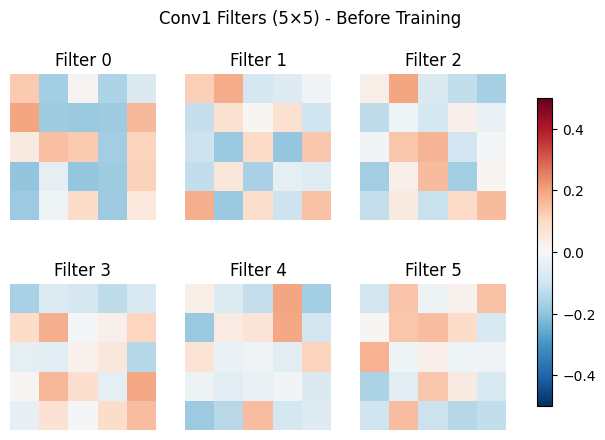


 These filters are randomly initialized. After training, they'll learn
  meaningful patterns like edges, corners, and textures.


In [42]:
# Visualize the learned filters (before training - random initialization)
print("="*60)
print("CONV1 FILTERS (Random Initialization)")
print("="*60)

# Get conv1 filters
conv1_filters = model.conv1.weight.data.cpu()

fig, axes = plt.subplots(2, 3, figsize=(8, 5))
fig.suptitle('Conv1 Filters (5×5) - Before Training', fontsize=12)

for idx, ax in enumerate(axes.flat):
    # Each filter has shape (1, 5, 5) - squeeze to (5, 5)
    filter_img = conv1_filters[idx, 0].numpy()
    
    im = ax.imshow(filter_img, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    ax.set_title(f'Filter {idx}')
    ax.axis('off')

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

print("\n These filters are randomly initialized. After training, they'll learn")
print("  meaningful patterns like edges, corners, and textures.")

## 5. Summary: LeNet-5 Architecture Complete

We have implemented LeNet-5, a classic CNN architecture perfectly suited for Fashion-MNIST. In each batch we have:

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                        LeNet-5 ARCHITECTURE SUMMARY                          │
└─────────────────────────────────────────────────────────────────────────────┘

    ┌─────────────┐     ┌─────────────┐     ┌─────────────┐     ┌─────────────┐
    │   INPUT     │     │   CONV1     │     │   CONV2     │     │  FC LAYERS  │
    │  (1,28,28)  │ ──► │  (6,24,24)  │ ──► │ (16,8,8)    │ ──► │  256→120→   │
    │             │     │  ↓Pool      │     │  ↓Pool      │     │  84→10      │
    │             │     │  (6,12,12)  │     │ (16,4,4)    │     │             │
    └─────────────┘     └─────────────┘     └─────────────┘     └─────────────┘
         │                    │                   │                    │
         ▼                    ▼                   ▼                    ▼
    Raw Pixels           Low-level          High-level            Class
                         Features           Features           Probabilities
```

**Key Takeaways**

| Concept | What We Learned |
|---------|----------------|
| **Convolution** | Local pattern detection with shared weights |
| **Pooling** | Spatial downsampling for translation invariance |
| **ReLU** | Non-linearity enabling complex decision boundaries |
| **Fully Connected** | Global reasoning for final classification |
| **nn.Module** | PyTorch's base class for neural networks |

**Model Statistics**

| Property | Value |
|----------|-------|
| Total Parameters | 44,426 |
| Trainable Parameters | 44,426 |
| Conv Parameters | 2,572 (5.8%) |
| FC Parameters | 41,854 (94.2%) |
| Input Shape | (batch, 1, 28, 28) |
| Output Shape | (batch, 10) |

**Next Steps**

With our model defined, we are ready to:
1. Define a loss function (Cross-Entropy)
2. Choose an optimizer (SGD, Adam, etc.)
3. Implement the training loop
4. Monitor training with validation data
5. Evaluate on the test set

# Step 3: Training the Neural Network

**Learning Objectives**

In this section, we bring everything together to **train our LeNet-5 model** on Fashion-MNIST. We will:

1. **Understand the training loop** — the core algorithm of deep learning
2. **Define a loss function** — Cross-Entropy for multi-class classification
3. **Choose an optimizer** — comparing SGD, SGD with momentum, and Adam
4. **Implement training with validation monitoring** — detecting overfitting
5. **Evaluate on the test set** — final unbiased performance assessment

**Key Takeaway**: Training a neural network is an iterative optimization process. Understanding each component (loss, optimizer, learning rate) is essential for diagnosing problems and improving performance.

## 1. The Training Loop

We will use the **Stochastic Gradient Descent (SGD)**

Computing the gradient over all $N$ samples is expensive. Instead, we use **mini-batches**:

$$\nabla_\theta \mathcal{L}(\theta) \approx \frac{1}{|B|} \sum_{i \in B} \nabla_\theta \ell(f_\theta(\mathbf{x}^{(i)}), y^{(i)})$$

where $B$ is a randomly sampled mini-batch. This is an **unbiased estimate** of the true gradient.

**Benefits of mini-batch SGD:**
1. **Computational efficiency**: Process batches that fit in GPU memory
2. **Regularization effect**: Gradient noise helps escape local minima
3. **Faster convergence**: More frequent parameter updates

**The Training Loop Structure**

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                           THE TRAINING LOOP                                  │
└─────────────────────────────────────────────────────────────────────────────┘

for epoch in range(num_epochs):           # Outer loop: multiple passes over data
    for batch in train_loader:            # Inner loop: iterate over mini-batches
        
        ┌─────────────────────────────────────────────────────────────────────┐
        │ 1. FORWARD PASS                                                      │
        │    predictions = model(inputs)     # Compute ŷ = f_θ(x)              │
        │    loss = criterion(predictions, targets)  # Compute ℓ(ŷ, y)         │
        └─────────────────────────────────────────────────────────────────────┘
                                    │
                                    ▼
        ┌─────────────────────────────────────────────────────────────────────┐
        │ 2. BACKWARD PASS                                                     │
        │    loss.backward()                 # Compute ∇_θ ℓ via backprop      │
        └─────────────────────────────────────────────────────────────────────┘
                                    │
                                    ▼
        ┌─────────────────────────────────────────────────────────────────────┐
        │ 3. PARAMETER UPDATE                                                  │
        │    optimizer.step()                # θ ← θ - η∇_θ ℓ                  │
        │    optimizer.zero_grad()           # Clear gradients for next batch  │
        └─────────────────────────────────────────────────────────────────────┘
```

## 2. Loss Function: Cross-Entropy for Classification

We will use the **Cross-Entropy**. For more details about the Loss functions please see **LossFunctions.ipynb**.

## 3. Optimizers: SGD, Momentum, and Adam

**3.1 Vanilla SGD**

The simplest optimizer:

$$\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}(\theta_t)$$

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
```

**Pros**: Simple, well-understood, good generalization
**Cons**: Slow convergence, sensitive to learning rate

**3.2 SGD with Momentum**

Adds a "velocity" term that accumulates past gradients:

$$\mathbf{v}_{t+1} = \mu \mathbf{v}_t + \nabla_\theta \mathcal{L}(\theta_t)$$
$$\theta_{t+1} = \theta_t - \eta \mathbf{v}_{t+1}$$

where $\mu \in [0, 1)$ is the momentum coefficient (typically 0.9).

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
```

**Intuition**: Like a ball rolling downhill, momentum helps:
- Accelerate through flat regions
- Dampen oscillations in ravines
- Escape shallow local minima

**3.3 Adam (Adaptive Moment Estimation)**

Adam combines momentum with **adaptive learning rates** per parameter:

$$\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \nabla_\theta \mathcal{L}$$
$$\mathbf{v}_t = \beta_2 \mathbf{v}_{t-1} + (1-\beta_2) (\nabla_\theta \mathcal{L})^2$$
$$\hat{\mathbf{m}}_t = \frac{\mathbf{m}_t}{1-\beta_1^t}, \quad \hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1-\beta_2^t}$$
$$\theta_{t+1} = \theta_t - \eta \frac{\hat{\mathbf{m}}_t}{\sqrt{\hat{\mathbf{v}}_t} + \epsilon}$$

Default hyperparameters: $\beta_1 = 0.9$, $\beta_2 = 0.999$, $\epsilon = 10^{-8}$

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
```

**Pros**: Fast convergence, less sensitive to learning rate, works well out-of-the-box
**Cons**: May generalize slightly worse than well-tuned SGD

**3.4 Comparison Summary**

| Optimizer | Learning Rate | Convergence | Generalization |
|-----------|---------------|-------------|----------------|
| SGD | ~0.01–0.1 | Slow | Good |
| SGD + Momentum | ~0.01–0.1 | Medium | Good |
| Adam | ~0.001 | Fast | Good (sometimes slightly worse) |

**For more details about the optimizers please check Optimizers.ipynb**

## 4. Implementation: Complete Training Pipeline

Now we implement the complete training pipeline with:
- Training loop with progress tracking
- Validation after each epoch
- Model checkpointing (saving the best model)
- Learning curves visualization

In [43]:
# Verify all required objects from previous steps are available
print("="*60)
print("VERIFYING PREREQUISITES FROM STEPS 1 & 2")
print("="*60)

# Check DataLoaders
print(f"\n✓ train_loader: {len(train_loader)} batches")
print(f"✓ val_loader: {len(val_loader)} batches")
print(f"✓ test_loader: {len(test_loader)} batches")

# Check model
print(f"\n Model: {type(model).__name__}")
print(f" Device: {device}")
print(f" Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Check other required variables
print(f"\n CLASS_NAMES: {len(CLASS_NAMES)} classes")
print(f" BATCH_SIZE: {BATCH_SIZE}")

VERIFYING PREREQUISITES FROM STEPS 1 & 2

✓ train_loader: 750 batches
✓ val_loader: 188 batches
✓ test_loader: 157 batches

 Model: LeNet5
 Device: mps
 Parameters: 44,426

 CLASS_NAMES: 10 classes
 BATCH_SIZE: 64


In [44]:
# ============================================================
# TRAINING CONFIGURATION
# ============================================================

# Hyperparameters
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# Loss function
# CrossEntropyLoss = LogSoftmax + NLLLoss (expects raw logits)
criterion = nn.CrossEntropyLoss()

# Optimizer - we'll use Adam for faster convergence
# Note: We create a fresh model to ensure clean initialization
model = LeNet5(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"\nModel: {type(model).__name__}")
print(f"Device: {device}")
print(f"\nHyperparameters:")
print(f"  • Epochs: {NUM_EPOCHS}")
print(f"  • Batch size: {BATCH_SIZE}")
print(f"  • Learning rate: {LEARNING_RATE}")
print(f"\nLoss function: {type(criterion).__name__}")
print(f"Optimizer: {type(optimizer).__name__}")
print(f"\nTraining samples: {len(train_loader.dataset):,}")
print(f"Validation samples: {len(val_loader.dataset):,}")
print(f"Test samples: {len(test_loader.dataset):,}")

TRAINING CONFIGURATION

Model: LeNet5
Device: mps

Hyperparameters:
  • Epochs: 15
  • Batch size: 64
  • Learning rate: 0.001

Loss function: CrossEntropyLoss
Optimizer: Adam

Training samples: 48,000
Validation samples: 12,000
Test samples: 10,000


In [45]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    
    Args:
        model: The neural network
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer for parameter updates
        device: Device to run on (cuda/mps/cpu)
    
    Returns:
        avg_loss: Average loss over all batches
        accuracy: Training accuracy (percentage)
    """
    model.train()  # Set model to training mode (enables dropout, batchnorm training behavior)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # =====================================================================
        # THE CORE TRAINING STEPS
        # =====================================================================
        
        # 1. Zero the gradients (PyTorch accumulates gradients by default)
        optimizer.zero_grad()
        
        # 2. Forward pass: compute predictions
        logits = model(images)  # Shape: (batch_size, num_classes)
        
        # 3. Compute loss
        loss = criterion(logits, labels)
        
        # 4. Backward pass: compute gradients
        loss.backward()
        
        # 5. Update parameters
        optimizer.step()
        
        # =====================================================================
        # TRACKING METRICS
        # =====================================================================
        
        running_loss += loss.item()
        
        # Compute accuracy
        _, predicted = torch.max(logits, dim=1)  # Get class with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


@torch.no_grad()  # Decorator to disable gradient computation
def evaluate(model, data_loader, criterion, device):
    """
    Evaluate the model on a dataset.
    
    Args:
        model: The neural network
        data_loader: DataLoader for evaluation data
        criterion: Loss function
        device: Device to run on
    
    Returns:
        avg_loss: Average loss over all batches
        accuracy: Accuracy (percentage)
    """
    model.eval()  # Set model to evaluation mode (disables dropout, uses running stats for batchnorm)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only (no gradient computation needed)
        logits = model(images)
        loss = criterion(logits, labels)
        
        running_loss += loss.item()
        
        _, predicted = torch.max(logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(data_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


print("Training and evaluation functions defined")

Training and evaluation functions defined


In [46]:
# ============================================================
# MAIN TRAINING LOOP
# ============================================================

import time

# Storage for learning curves
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# For model checkpointing
best_val_acc = 0.0
best_model_state = None

print("="*60)
print("TRAINING STARTED")
print("="*60)
print(f"\n{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>10} | {'Val Loss':>10} | {'Val Acc':>10} | {'Time':>8}")
print("-" * 70)

total_start_time = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Evaluate on validation set
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )
    
    epoch_time = time.time() - epoch_start_time
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Model checkpointing: save if validation accuracy improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        checkpoint_marker = " ★"
    else:
        checkpoint_marker = ""
    
    # Print progress
    print(f"{epoch:>5} | {train_loss:>10.4f} | {train_acc:>9.2f}% | {val_loss:>10.4f} | {val_acc:>9.2f}% | {epoch_time:>7.2f}s{checkpoint_marker}")

total_time = time.time() - total_start_time

print("-" * 70)
print(f"\nTraining completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

TRAINING STARTED

Epoch | Train Loss |  Train Acc |   Val Loss |    Val Acc |     Time
----------------------------------------------------------------------
    1 |     0.6431 |     76.38% |     0.4611 |     82.91% |   11.51s ★
    2 |     0.3944 |     85.51% |     0.3825 |     86.25% |    8.32s ★
    3 |     0.3424 |     87.45% |     0.3520 |     87.08% |    8.19s ★
    4 |     0.3134 |     88.29% |     0.3205 |     88.30% |    8.21s ★
    5 |     0.2935 |     89.06% |     0.3240 |     87.85% |    8.25s
    6 |     0.2765 |     89.73% |     0.2966 |     89.04% |    8.28s ★
    7 |     0.2622 |     90.30% |     0.2993 |     89.12% |    8.22s ★
    8 |     0.2512 |     90.72% |     0.2957 |     89.52% |    8.34s ★
    9 |     0.2388 |     91.15% |     0.2881 |     89.62% |    8.32s ★
   10 |     0.2270 |     91.42% |     0.3040 |     89.18% |    8.74s
   11 |     0.2178 |     91.77% |     0.3066 |     89.09% |   10.33s
   12 |     0.2078 |     92.20% |     0.2768 |     90.28% |    8.31

In [47]:
# Load the best model (with highest validation accuracy)
print("="*60)
print("LOADING BEST MODEL")
print("="*60)

model.load_state_dict(best_model_state)
print(f"\nLoaded model with best validation accuracy: {best_val_acc:.2f}%")

LOADING BEST MODEL

Loaded model with best validation accuracy: 90.28%


## 5. Visualizing Training Progress

**Learning Curves** show how loss and accuracy evolve during training. They help diagnose:

| Pattern | Interpretation | Action |
|---------|----------------|--------|
| Both decreasing, then plateau | Normal convergence | Training complete |
| Train ↓, Val ↑ | **Overfitting** | Add regularization, early stopping |
| Both high, not decreasing | **Underfitting** | Increase capacity, train longer |
| Large gap between train/val | Overfitting | Add dropout, data augmentation |

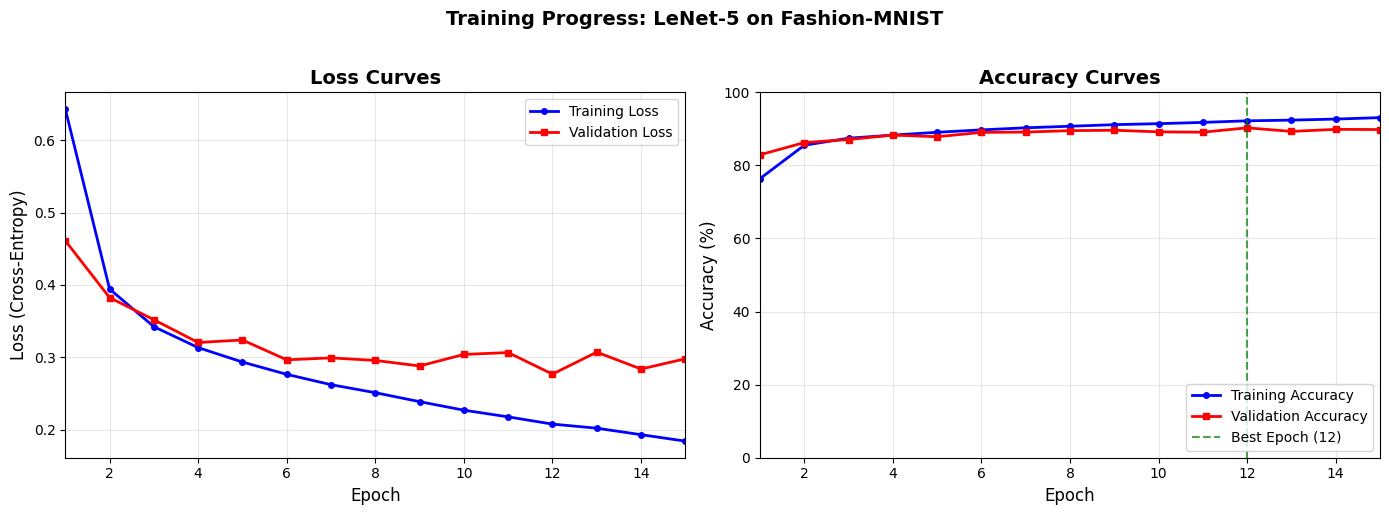


TRAINING ANALYSIS

Final Training Accuracy:   93.08%
Final Validation Accuracy: 89.82%
Generalization Gap:        3.26%

→ Moderate generalization gap. Model may be slightly overfitting.


In [48]:
# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, NUM_EPOCHS + 1)

# Plot 1: Loss curves
ax1 = axes[0]
ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
ax1.plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (Cross-Entropy)', fontsize=12)
ax1.set_title('Loss Curves', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, NUM_EPOCHS)

# Plot 2: Accuracy curves
ax2 = axes[1]
ax2.plot(epochs, history['train_acc'], 'b-', linewidth=2, label='Training Accuracy', marker='o', markersize=4)
ax2.plot(epochs, history['val_acc'], 'r-', linewidth=2, label='Validation Accuracy', marker='s', markersize=4)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy Curves', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, NUM_EPOCHS)
ax2.set_ylim(0, 100)

# Mark best epoch
best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
ax2.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax2.legend(loc='lower right', fontsize=10)

plt.suptitle('Training Progress: LeNet-5 on Fashion-MNIST', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print analysis
print("\n" + "="*60)
print("TRAINING ANALYSIS")
print("="*60)

final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
gap = final_train_acc - final_val_acc

print(f"\nFinal Training Accuracy:   {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Generalization Gap:        {gap:.2f}%")

if gap < 3:
    print("\n→ Low generalization gap indicates good model fit.")
elif gap < 10:
    print("\n→ Moderate generalization gap. Model may be slightly overfitting.")
else:
    print("\n→ Large generalization gap! Consider adding regularization.")

## 6. Evaluation on Test Set

**6.1 The Importance of the Test Set**

The test set provides an **unbiased estimate** of model performance on unseen data:

- **Training set**: Used to update parameters → optimistically biased
- **Validation set**: Used for hyperparameter tuning → slightly biased
- **Test set**: Never used during training → unbiased estimate

**Golden Rule**: Only evaluate on the test set **once**, after all model development is complete. Otherwise, you risk overfitting to the test set through repeated evaluation.

**6.2 Metrics for Classification**

Beyond accuracy, we'll compute:
- **Per-class accuracy**: Which classes are harder to classify?
- **Confusion matrix**: Which classes are confused with each other?

In [49]:
# ============================================================
# FINAL EVALUATION ON TEST SET
# ============================================================

print("="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"\nCorrectly classified: {int(test_acc * len(test_loader.dataset) / 100):,} / {len(test_loader.dataset):,} images")

FINAL EVALUATION ON TEST SET

Test Loss:     0.3159
Test Accuracy: 89.34%

Correctly classified: 8,934 / 10,000 images


In [50]:
# ============================================================
# PER-CLASS ACCURACY ANALYSIS
# ============================================================

@torch.no_grad()
def compute_per_class_accuracy(model, data_loader, device, num_classes=10):
    """
    Compute accuracy for each class separately.
    
    Returns:
        class_correct: Number of correct predictions per class
        class_total: Total samples per class
        all_predictions: All predictions (for confusion matrix)
        all_labels: All true labels
    """
    model.eval()
    
    class_correct = torch.zeros(num_classes)
    class_total = torch.zeros(num_classes)
    
    all_predictions = []
    all_labels = []
    
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        _, predicted = torch.max(logits, dim=1)
        
        # Store for confusion matrix
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Per-class accuracy
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == labels[i]:
                class_correct[label] += 1
    
    return class_correct, class_total, np.array(all_predictions), np.array(all_labels)


# Compute per-class metrics
class_correct, class_total, all_preds, all_labels = compute_per_class_accuracy(
    model, test_loader, device
)

print("="*60)
print("PER-CLASS ACCURACY ON TEST SET")
print("="*60)
print(f"\n{'Class':<15} {'Correct':<10} {'Total':<10} {'Accuracy':>10}")
print("-" * 50)

for i, name in enumerate(CLASS_NAMES):
    acc = 100.0 * class_correct[i] / class_total[i]
    print(f"{name:<15} {int(class_correct[i]):<10} {int(class_total[i]):<10} {acc:>9.2f}%")

print("-" * 50)
print(f"{'Overall':<15} {int(class_correct.sum()):<10} {int(class_total.sum()):<10} {test_acc:>9.2f}%")

# Identify hardest and easiest classes
class_accuracies = 100.0 * class_correct / class_total
easiest_idx = torch.argmax(class_accuracies).item()
hardest_idx = torch.argmin(class_accuracies).item()

print(f"\nEasiest class: {CLASS_NAMES[easiest_idx]} ({class_accuracies[easiest_idx]:.2f}%)")
print(f"Hardest class: {CLASS_NAMES[hardest_idx]} ({class_accuracies[hardest_idx]:.2f}%)")

PER-CLASS ACCURACY ON TEST SET

Class           Correct    Total        Accuracy
--------------------------------------------------
T-shirt/top     851        1000           85.10%
Trouser         984        1000           98.40%
Pullover        891        1000           89.10%
Dress           848        1000           84.80%
Coat            740        1000           74.00%
Sandal          974        1000           97.40%
Shirt           749        1000           74.90%
Sneaker         961        1000           96.10%
Bag             979        1000           97.90%
Ankle boot      957        1000           95.70%
--------------------------------------------------
Overall         8934       10000          89.34%

Easiest class: Trouser (98.40%)
Hardest class: Coat (74.00%)


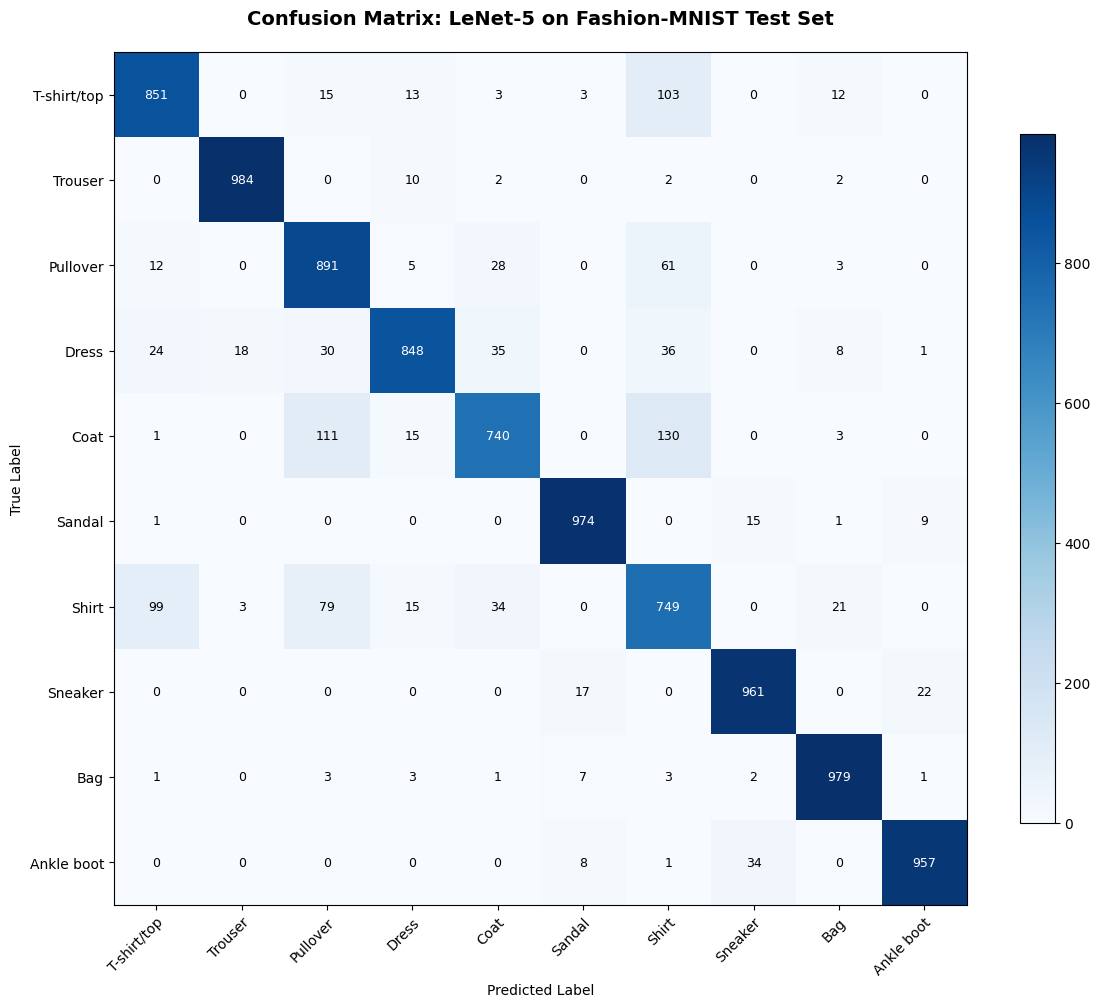


COMMON MISCLASSIFICATIONS

Top 5 most common confusions:
  • Coat → Shirt: 130 times
  • Coat → Pullover: 111 times
  • T-shirt/top → Shirt: 103 times
  • Shirt → T-shirt/top: 99 times
  • Shirt → Pullover: 79 times


In [51]:
# ============================================================
# CONFUSION MATRIX
# ============================================================

from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax, shrink=0.8)

# Configure axes
ax.set(
    xticks=np.arange(len(CLASS_NAMES)),
    yticks=np.arange(len(CLASS_NAMES)),
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    ylabel='True Label',
    xlabel='Predicted Label'
)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
thresh = cm.max() / 2.
for i in range(len(CLASS_NAMES)):
    for j in range(len(CLASS_NAMES)):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=9)

ax.set_title('Confusion Matrix: LeNet-5 on Fashion-MNIST Test Set', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Analyze common confusions
print("\n" + "="*60)
print("COMMON MISCLASSIFICATIONS")
print("="*60)

# Find the most common confusions (off-diagonal elements)
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Get top 5 confusions
top_confusions = []
for _ in range(5):
    idx = np.unravel_index(np.argmax(cm_no_diag), cm_no_diag.shape)
    if cm_no_diag[idx] > 0:
        top_confusions.append((idx[0], idx[1], cm_no_diag[idx]))
        cm_no_diag[idx] = 0

print("\nTop 5 most common confusions:")
for true_idx, pred_idx, count in top_confusions:
    print(f"  • {CLASS_NAMES[true_idx]} → {CLASS_NAMES[pred_idx]}: {int(count)} times")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


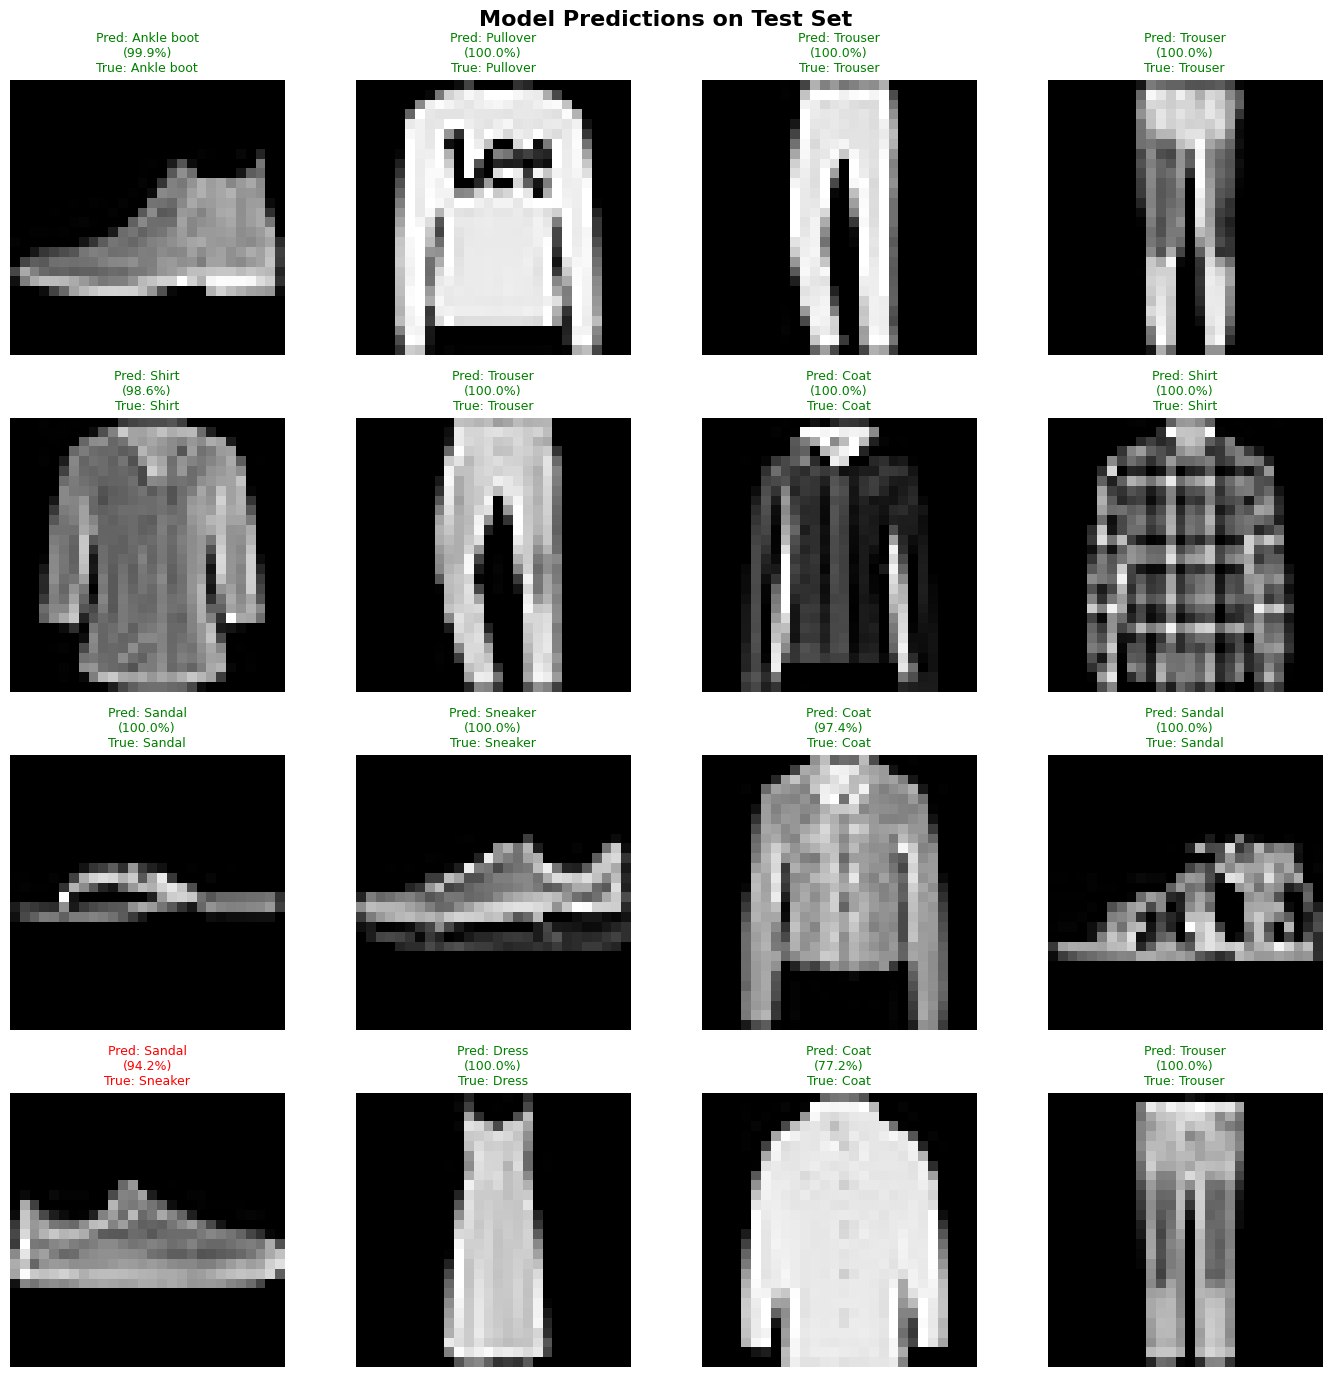

In [52]:
# ============================================================
# VISUALIZE SAMPLE PREDICTIONS
# ============================================================

@torch.no_grad()
def visualize_predictions(model, data_loader, device, num_samples=16):
    """
    Visualize model predictions on sample images.
    Green title = correct, Red title = incorrect
    """
    model.eval()
    
    # Get a batch
    images, labels = next(iter(data_loader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]
    
    # Get predictions
    logits = model(images)
    probs = torch.softmax(logits, dim=1)
    confidences, predicted = torch.max(probs, dim=1)
    
    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    fig.suptitle('Model Predictions on Test Set', fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flat):
        # Denormalize image for display
        img = images[i].cpu().squeeze()
        img_display = img * FASHION_MNIST_STD[0] + FASHION_MNIST_MEAN[0]
        
        ax.imshow(img_display, cmap='gray')
        
        true_label = labels[i].item()
        pred_label = predicted[i].item()
        confidence = confidences[i].item() * 100
        
        # Color code: green = correct, red = incorrect
        color = 'green' if pred_label == true_label else 'red'
        
        title = f"Pred: {CLASS_NAMES[pred_label]}\n({confidence:.1f}%)\nTrue: {CLASS_NAMES[true_label]}"
        ax.set_title(title, fontsize=9, color=color)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_predictions(model, test_loader, device)

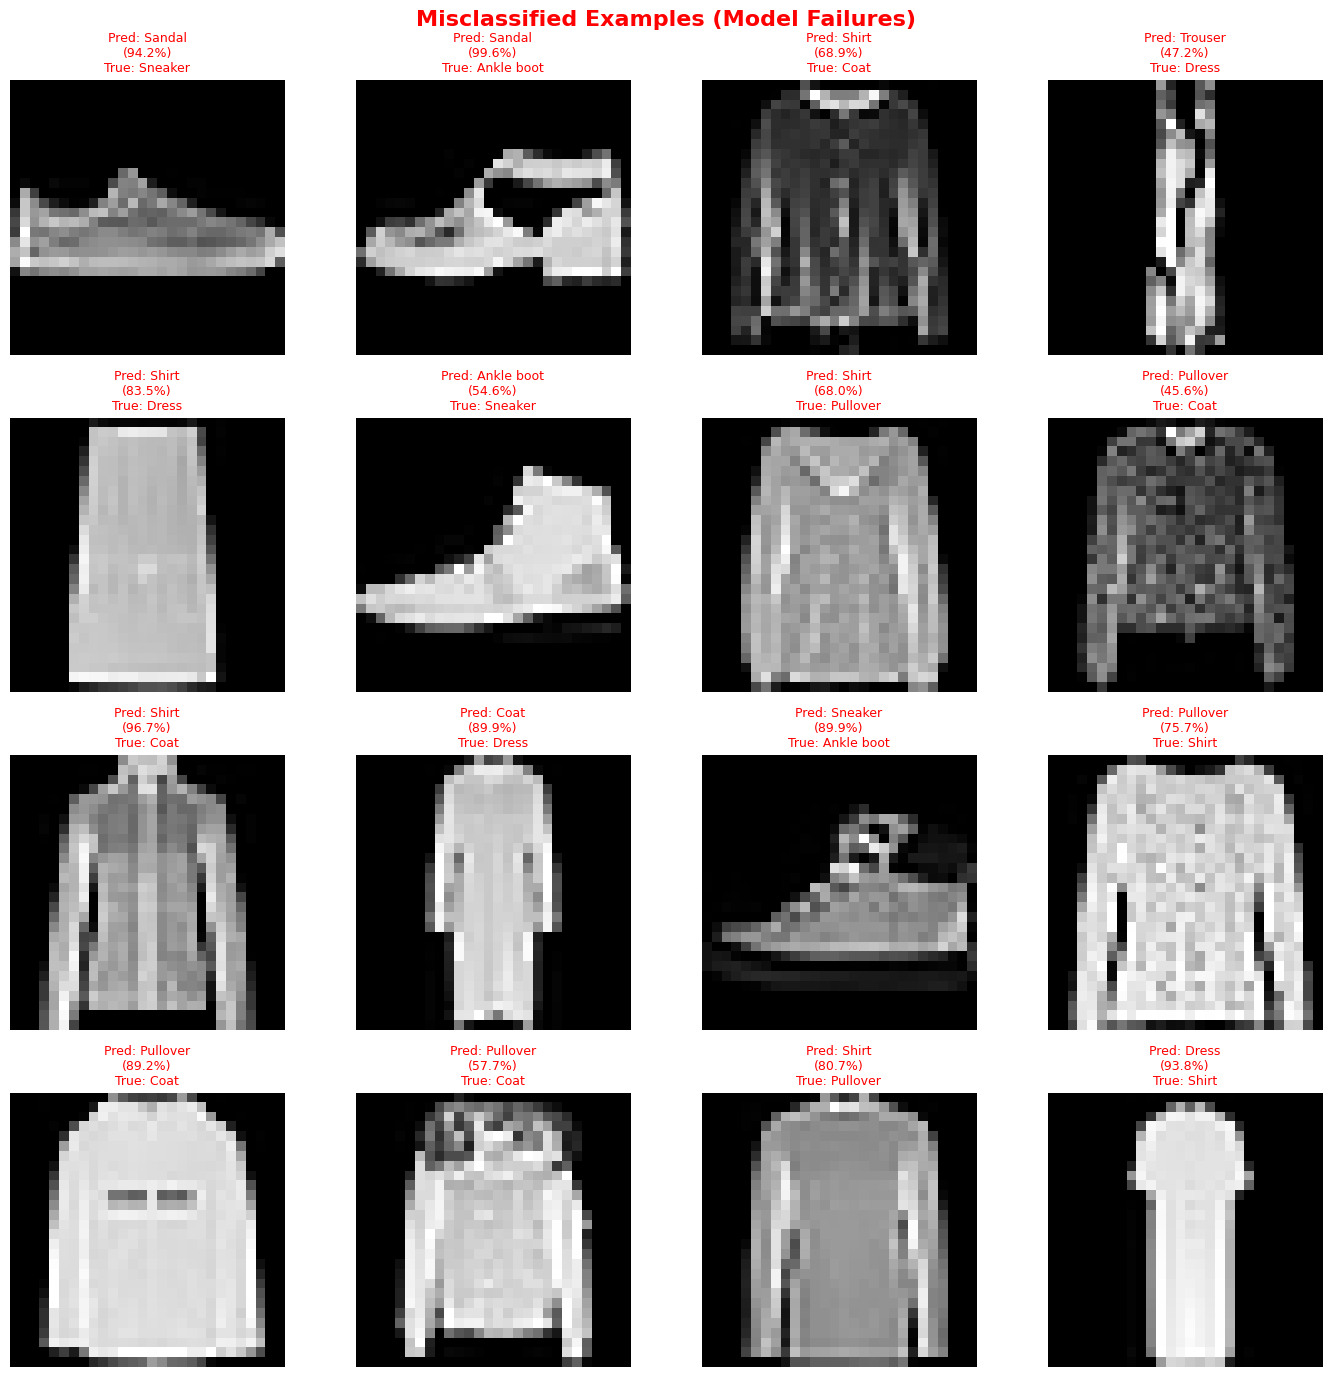


Note: Many misclassifications occur between visually similar categories
like Shirt↔T-shirt, Coat↔Pullover, Sneaker↔Ankle boot.


In [53]:
# ============================================================
# VISUALIZE MISCLASSIFIED EXAMPLES
# ============================================================

@torch.no_grad()
def visualize_misclassifications(model, data_loader, device, num_samples=16):
    """
    Visualize misclassified examples to understand model failures.
    """
    model.eval()
    
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_confs = []
    
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        probs = torch.softmax(logits, dim=1)
        confidences, predicted = torch.max(probs, dim=1)
        
        # Find misclassified samples
        mask = predicted != labels
        
        for i in torch.where(mask)[0]:
            if len(misclassified_images) >= num_samples:
                break
            misclassified_images.append(images[i].cpu())
            misclassified_labels.append(labels[i].item())
            misclassified_preds.append(predicted[i].item())
            misclassified_confs.append(confidences[i].item())
        
        if len(misclassified_images) >= num_samples:
            break
    
    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    fig.suptitle('Misclassified Examples (Model Failures)', fontsize=16, fontweight='bold', color='red')
    
    for i, ax in enumerate(axes.flat):
        if i >= len(misclassified_images):
            ax.axis('off')
            continue
            
        # Denormalize image for display
        img = misclassified_images[i].squeeze()
        img_display = img * FASHION_MNIST_STD[0] + FASHION_MNIST_MEAN[0]
        
        ax.imshow(img_display, cmap='gray')
        
        title = f"Pred: {CLASS_NAMES[misclassified_preds[i]]}\n({misclassified_confs[i]*100:.1f}%)\nTrue: {CLASS_NAMES[misclassified_labels[i]]}"
        ax.set_title(title, fontsize=9, color='red')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_misclassifications(model, test_loader, device)

print("\nNote: Many misclassifications occur between visually similar categories")
print("like Shirt↔T-shirt, Coat↔Pullover, Sneaker↔Ankle boot.")

## 7. Summary: What We Learned

In [54]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print("="*70)
print("                    TRAINING COMPLETE: FINAL SUMMARY                    ")
print("="*70)

print("\n┌─────────────────────────────────────────────────────────────────────┐")
print("│                         MODEL CONFIGURATION                          │")
print("└─────────────────────────────────────────────────────────────────────┘")
print(f"  Architecture:     LeNet-5 (adapted for 28×28 input)")
print(f"  Parameters:       {sum(p.numel() for p in model.parameters()):,}")
print(f"  Device:           {device}")

print("\n┌─────────────────────────────────────────────────────────────────────┐")
print("│                       TRAINING CONFIGURATION                         │")
print("└─────────────────────────────────────────────────────────────────────┘")
print(f"  Epochs:           {NUM_EPOCHS}")
print(f"  Batch size:       {BATCH_SIZE}")
print(f"  Learning rate:    {LEARNING_RATE}")
print(f"  Optimizer:        {type(optimizer).__name__}")
print(f"  Loss function:    {type(criterion).__name__}")

print("\n┌─────────────────────────────────────────────────────────────────────┐")
print("│                           FINAL RESULTS                              │")
print("└─────────────────────────────────────────────────────────────────────┘")
print(f"  Training Accuracy:    {history['train_acc'][-1]:.2f}%")
print(f"  Validation Accuracy:  {history['val_acc'][-1]:.2f}%")
print(f"  Test Accuracy:        {test_acc:.2f}%")
print(f"  Best Epoch:           {best_epoch}")
print(f"  Training Time:        {total_time:.2f}s")

print("\n┌─────────────────────────────────────────────────────────────────────┐")
print("│                         KEY TAKEAWAYS                                │")
print("└─────────────────────────────────────────────────────────────────────┘")
print("""
  1. The TRAINING LOOP is the core algorithm:
     Forward → Loss → Backward → Update → Repeat

  2. CROSS-ENTROPY LOSS is ideal for classification:
     - Expects raw logits (not softmax)
     - Penalizes confident wrong predictions heavily

  3. ADAM OPTIMIZER provides fast convergence:
     - Adaptive learning rates per parameter
     - Good default choice for most problems

  4. VALIDATION MONITORING prevents overfitting:
     - Save the best model during training
     - Watch for train-val gap increasing

  5. TEST SET gives unbiased performance:
     - Only evaluate once, after all development
     - Analyze per-class performance to understand failures
""")

print("="*70)
print("                         END OF TRAINING NOTEBOOK                       ")
print("="*70)

                    TRAINING COMPLETE: FINAL SUMMARY                    

┌─────────────────────────────────────────────────────────────────────┐
│                         MODEL CONFIGURATION                          │
└─────────────────────────────────────────────────────────────────────┘
  Architecture:     LeNet-5 (adapted for 28×28 input)
  Parameters:       44,426
  Device:           mps

┌─────────────────────────────────────────────────────────────────────┐
│                       TRAINING CONFIGURATION                         │
└─────────────────────────────────────────────────────────────────────┘
  Epochs:           15
  Batch size:       64
  Learning rate:    0.001
  Optimizer:        Adam
  Loss function:    CrossEntropyLoss

┌─────────────────────────────────────────────────────────────────────┐
│                           FINAL RESULTS                              │
└─────────────────────────────────────────────────────────────────────┘
  Training Accuracy:    93.08%
  V

## 8. Next Steps (Optional Exercises)

**To further improve the model, we may consider:**

1. **Data Augmentation**: Add random transformations (rotation, flip, crop) to increase training data diversity

2. **Learning Rate Scheduling**: Reduce learning rate as training progresses
   ```python
   scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
   ```

3. **Regularization**: Add dropout or weight decay to reduce overfitting
   ```python
   optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
   ```

4. **Deeper Architectures**: Try VGG-style or ResNet-style architectures

5. **Compare Optimizers**: Train with SGD, SGD+Momentum, and Adam to see differences